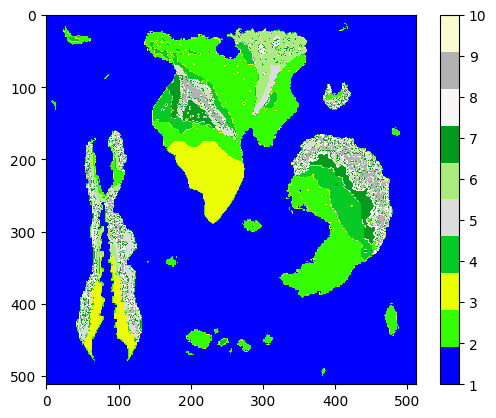

In [20]:
from worldgen.image import load_image, patch, extract_biomes
from worldgen.visualization import colormap_biomes, visualize_biomes
import numpy as np
import matplotlib.pyplot as plt

goal = 65536
base = 512
scale = base * 128
patches = 8
patch_window = int(base / patches)
biome_count = 10

world_image = load_image("./assets/pinnacle.png", base)
world, biomes = extract_biomes(world_image, biome_count)

visualize_biomes(world, biomes, base)

In [21]:
cmap = colormap_biomes(biomes)
biome_map = world['label'].values.reshape(base, base, 1)

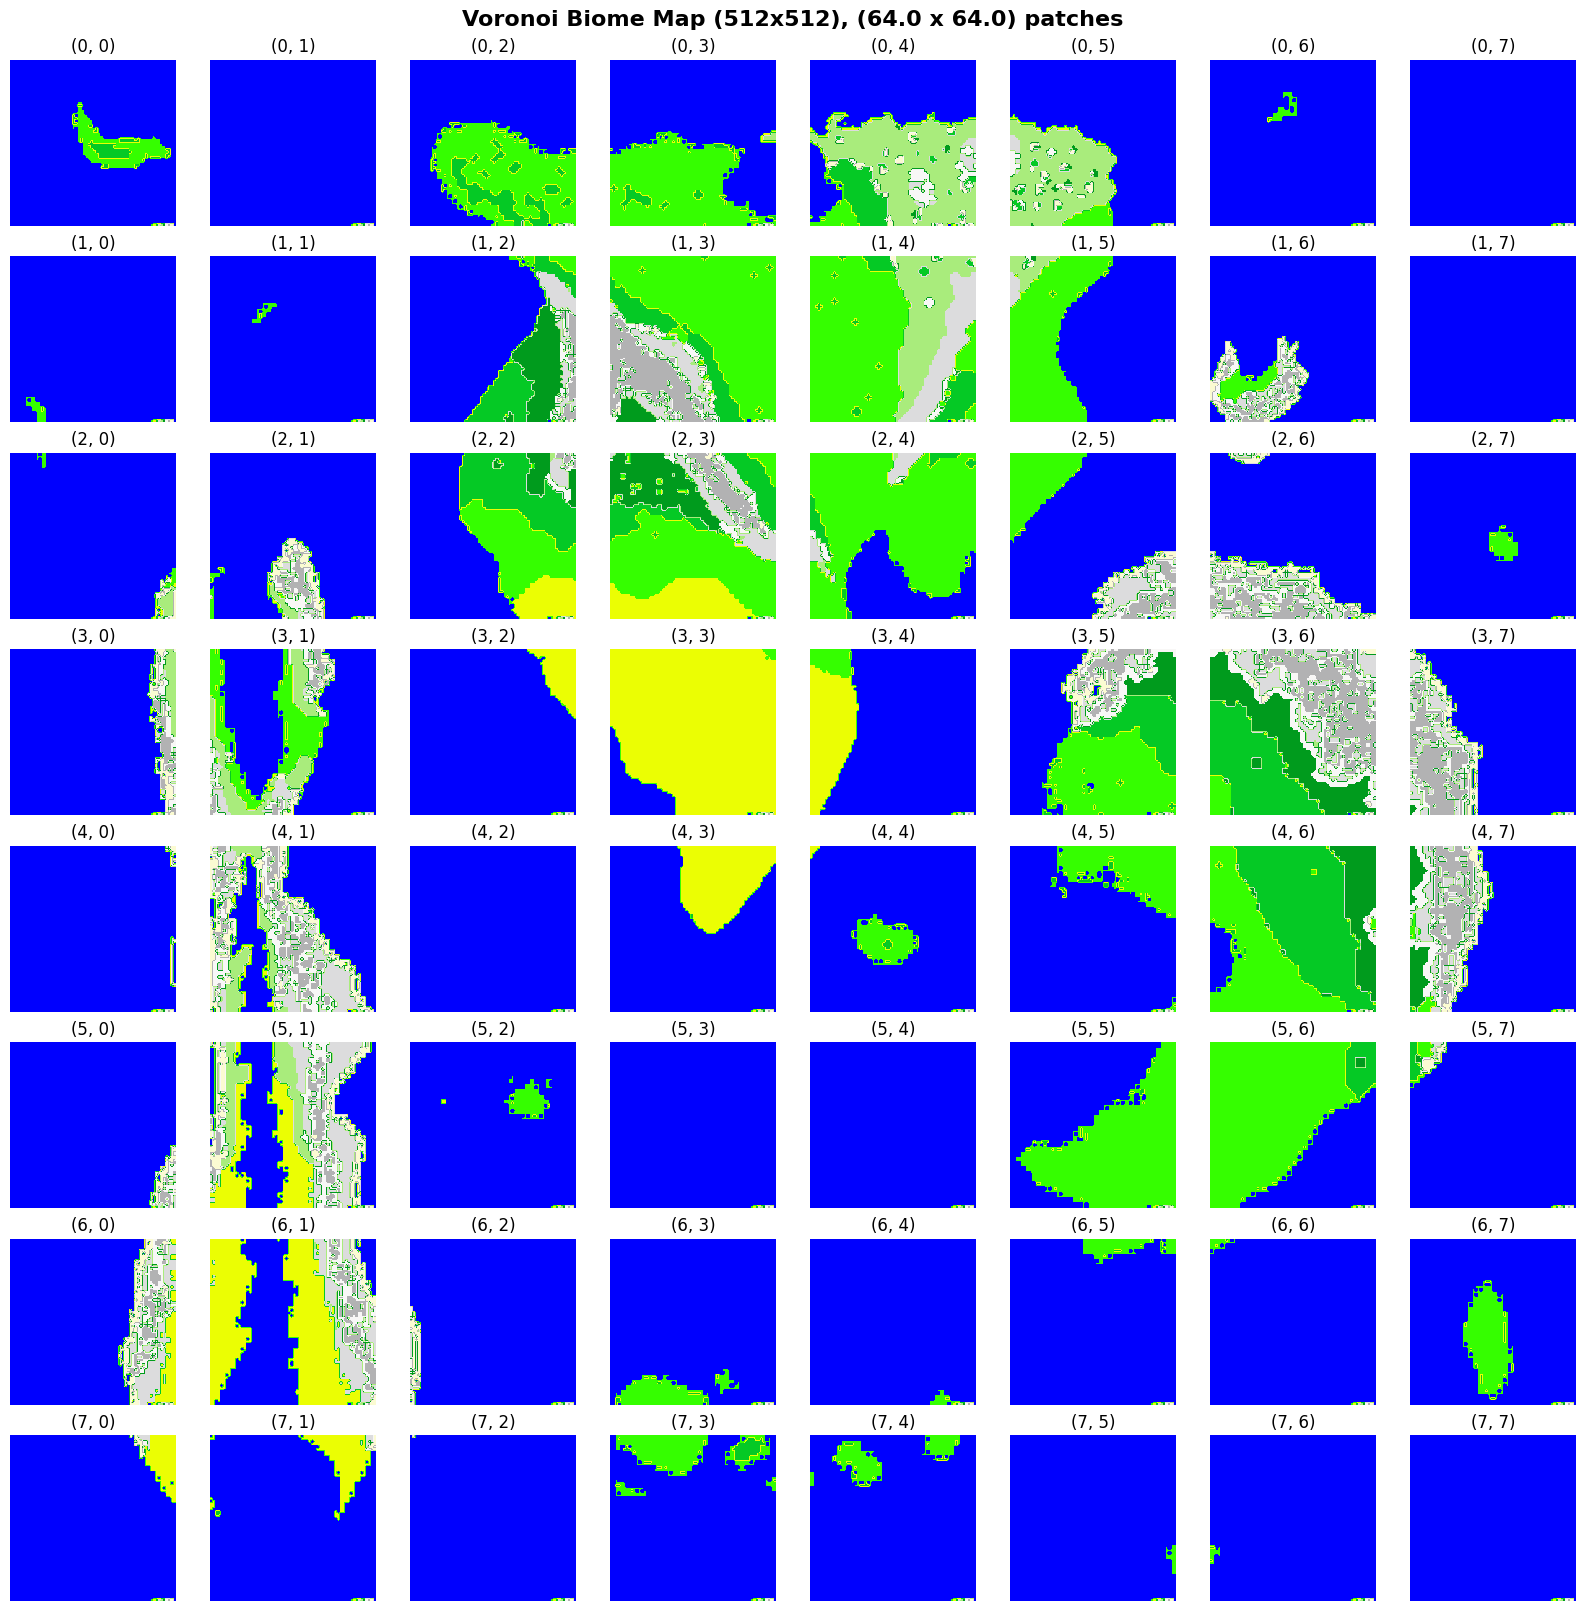

In [22]:
# Create an 8x8 figure, minimize the margins, and set the spacing to 0
fig, ax = plt.subplots(patches, patches, figsize=(16, 16), constrained_layout=True, squeeze=False)
fig.suptitle(f'Voronoi Biome Map ({base}x{base}), ({base / patches} x {base / patches}) patches', fontsize=16, fontweight='bold')

# Iterate over the axes and plot the patches
for i in range(0, patches):
    for j in range(0, patches):
        segment = patch(i, j, biome_map, int(base / patches)).copy()

        segment[-1, -biome_count-1:-1, 0] = biomes.index.values[:-1]
        ax[i, j].imshow(segment, cmap=cmap)
        ax[i, j].axis('off')
        ax[i, j].set_xticks([])
        ax[i, j].set_yticks([])
        ax[i, j].set_title(f'({i}, {j})')


plt.show()

In [23]:
from worldgen.voronoi import get_voronoi, voronoi_finite_polygons_2d, clip_to_bounds, rasterize_voronoi
from worldgen.voronoi import voronoi_array
from worldgen.visualization import visualize_zones
from IPython.display import clear_output

def super_resolution(zone_map : np.ndarray, base : int, patches: int, zoom : int, poly_count : int = 6096) -> np.ndarray:
    layers = np.zeros((base * zoom, base * zoom), dtype=np.uint8)
    for u in range(patches):
        for v in range(patches):
            patch_window = int(base / patches)
            x = u * patch_window * zoom
            y = v * patch_window * zoom
            layer_window = patch_window * zoom
            print(f'({u}, {v}) -> ({x}, {y}) / {layer_window}')

            patch_map = patch(u, v, zone_map, patch_window)
            patch_map = np.flip(patch_map, 0)
            vzones = voronoi_array(patch_map, 4096, layer_window)
            print(vzones.shape, layer_window, layers.shape)
            #vzones = LoG_erode(vzones, biomes, 1, 0, 4)
            layers[x:x+layer_window, y:y+layer_window] = vzones
            # clear ipython output
            clear_output(wait=True)
            plt.imshow(layers, cmap=cmap)
            plt.show()
    return layers


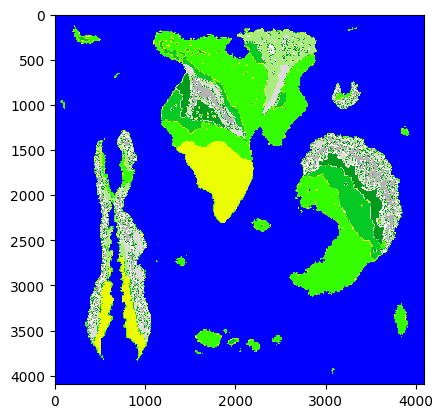

In [24]:
zone_map_4096 = super_resolution(biome_map, base, 8, 8, 6096)

In [19]:
zone_map_4096.shape, zone_map_4096, biomes
import numpy as np
import pandas as pd
from PIL import Image

# Assuming your data is in the following format
zone_map = zone_map_4096

zone_dataframe = biomes

# Create an image in P mode with the right size
img = Image.new('P', (4096, 4096))

# Prepare the color palette
palette = []

palette.extend((0, 0, 0))
for _, (r, g, b) in zone_dataframe.iterrows():
    palette.extend((r, g, b))

# There can only be 256 different colors in P mode,
# so we fill the rest of the 768 values with zeros.
while len(palette) < 768:
    palette.extend((0, 0, 0))

img.putpalette(palette)

# Map the zone_map values to the palette
img.putdata(zone_map.flatten())

# Save the image to a file
img.save('output_image_palette.png')


c:\Users\user\projects\pinnacle-haxe\worldgen\worldgen\visualization.py:116: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


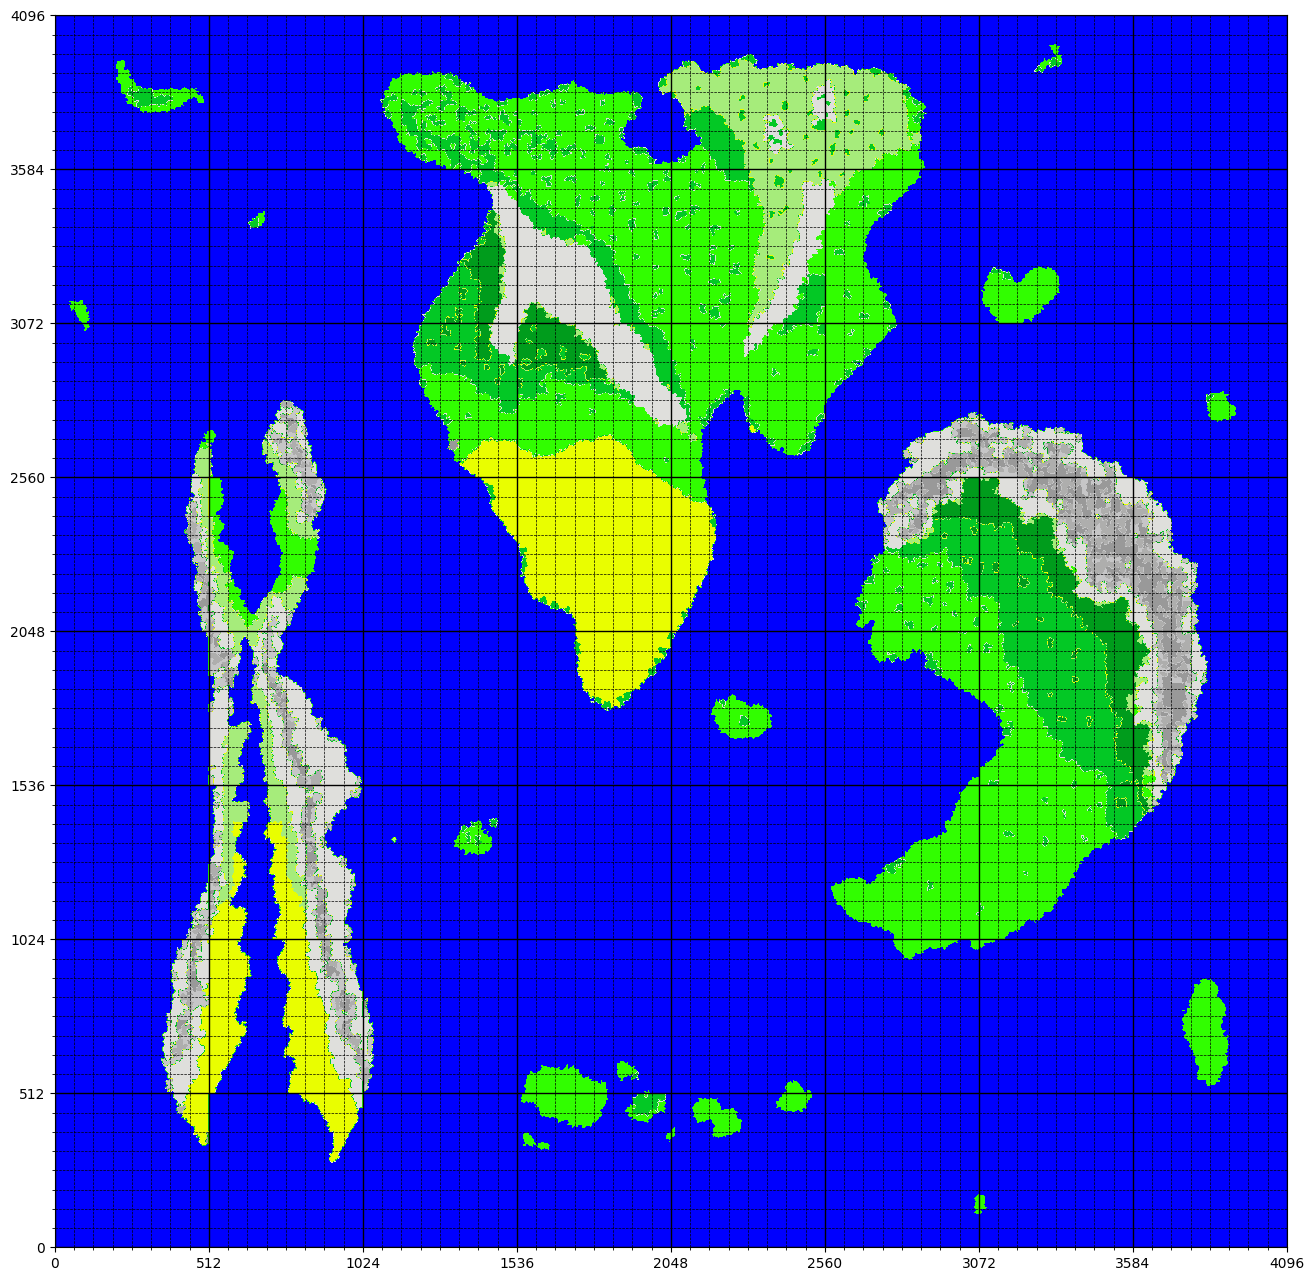

In [11]:
%matplotlib inline
#fig, ax = plt.subplots(1, 1, figsize=(16, 16), constrained_layout=True, squeeze=False)
#ax[0, 0].imshow(layers, cmap=cmap)
visualize_zones(zone_map_4096, biomes, 64)

pass 0
biome 1
biome 2
biome 3
biome 4
biome 5
biome 6
biome 7
biome 8
biome 9
biome 10


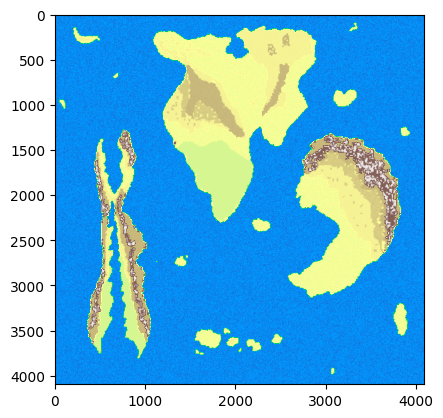

generated heightmap of shape (4096, 4096)
applying fractal noise [1, 0.001, 4.8, 0.5]


KeyboardInterrupt: 

In [12]:
# We need to fit a heightmap to our world map.  There are 10 biomes:
# 1 - Ocean
# 2 - Grassland
# 3 - Hills
# 4 - Woodland
# 5 - Desert
# 6 - Tundra
# 7 - Forest
# 8 - Mountain
# 9 - Alpine
# 10 - Peaks
import numpy as np
from scipy.ndimage import gaussian_filter
from worldgen.heightmap import create_perlin


# The biome_rules have been completed with some assumptions
biome_rules = {
    1: {'min_height': -100, 'max_height': -1, 'alpha': 2, 'clip': True},  # Ocean
    2: {'min_height': 0, 'max_height': 20, 'alpha': 3, 'clip': True},  # Grassland
    3: {'min_height': 20, 'max_height': 40, 'alpha': 4, 'clip': True},  # Hills
    4: {'min_height': 10, 'max_height': 20, 'alpha': 3, 'clip': False},  # Woodland
    5: {'min_height': 0, 'max_height': 10, 'alpha': 5, 'clip': True},  # Desert
    6: {'min_height': 10, 'max_height': 20, 'alpha': 4, 'clip': True},  # Tundra
    7: {'min_height': 10, 'max_height': 40, 'alpha': 3, 'clip': False},  # Forest
    8: {'min_height': 40, 'max_height': 70, 'alpha': 2, 'clip': True},  # Mountain
    9: {'min_height': 60, 'max_height': 80, 'alpha': 1, 'clip': True},  # Alpine
    10: {'min_height': 80, 'max_height': 100, 'alpha': 1, 'clip': True}  # Peaks
}

def generate_heightmap(zone_map : np.ndarray, passes: int=3) -> np.ndarray:
    """This function generates a heightmap from a world map."""
    heightmap = np.zeros_like(zone_map, dtype=np.float32)

    # Multiple passes over the same map for smoothing
    for p in range(passes):
        print('pass', p)
        for biome, rules in biome_rules.items():
            print('biome', biome)
            mask = zone_map == biome
            random_heights = np.random.uniform(rules['min_height'], rules['max_height'], size=zone_map.shape)
            
            # apply the smoothing with a sigma specific to the biome
            smoothed_heights = gaussian_filter(random_heights, sigma=rules['alpha'])
            
            # Enforce minimum and maximum heights if 'clip' rule is True
            if rules['clip']:
                smoothed_heights = np.clip(smoothed_heights, rules['min_height'], rules['max_height'])
            
            # only apply smoothed heights to the respective biome
            heightmap[mask] = smoothed_heights[mask]

    return heightmap

import random

config = {
    'xoffset': random.randint(0, 100000),
    'yoffset': random.randint(0, 100000),
}
center = (config['xoffset'], config['yoffset'])

levels = [
    [[1, .001, 4.8, .5], 5],
    [[1, .003, 4.1, .9], 2],
    [[5, .039, 2.4, .7], 3],
    [[6, .014, 5, .7], 5],
]
hm = generate_heightmap(zone_map_4096, 1)
plt.imshow(hm, cmap='terrain')
plt.show()
print('generated heightmap of shape', hm.shape)
for i, (level, w) in enumerate(levels, 1):
    print('applying fractal noise', level)
    pn = create_perlin(hm.shape, center, *level)
    pn[pn < 0] = 0
    pn *= w
    hm += pn
    u, v = i // 2, i % 2
    plt.imshow(pn, cmap='terrain')
    plt.show()


In [ ]:
level = [1, 0.002, 4.8, 0.5]
pn = create_perlin(hm.shape, center, *level)
pn[pn < 0] = 0
pn *= 4
hm += pn
u, v = i // 2, i % 2
plt.imshow(pn, cmap='terrain')
plt.show()
#plt.imshow(hm, cmap='terrain')

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import random
from scipy import ndimage
import skimage

def generate_temperature_map(heightmap):
    temperature_map = np.max(heightmap) - heightmap  # basic inversion to get colder temps at high altitudes
    # add gradient to simulate latitude
    gradient = np.linspace(0.5, 1.5, num=heightmap.shape[1], endpoint=True)
    temperature_map *= gradient
    return temperature_map

def generate_river_map(heightmap, temperature_map):
    river_map = np.zeros_like(heightmap)

    # Compute the direction of flow based on the steepest descent (D8 algorithm)
    x_gradient, y_gradient = np.gradient(-heightmap)  # use -heightmap to make water flow downhill
    flow_direction = np.arctan2(y_gradient, x_gradient)

    # create initial river seeds at local maxima
    maxima = ndimage.maximum_filter(heightmap, size=5)
    seeds = np.argwhere((heightmap == maxima) & (heightmap > np.percentile(heightmap, 90)))

    # iteratively expand the seeds
    for seed in seeds:
        y, x = seed
        while 0 <= y < heightmap.shape[0] and 0 <= x < heightmap.shape[1]:
            river_map[y, x] = 1
            dy, dx = np.sin(flow_direction[y, x]), np.cos(flow_direction[y, x])
            y, x = int(y + dy), int(x + dx)
    return river_map

def generate_river_map(heightmap):
    river_map = np.zeros_like(heightmap)

    # Create initial river seeds at local maxima
    maxima = ndimage.maximum_filter(heightmap, size=5)
    seeds = np.argwhere((heightmap == maxima) & (heightmap > np.percentile(heightmap, 99)))
    seeds = np.random.permutation(seeds)[:2]
    seeds[0] = [1000, 1500]

    # define offsets for 3x3, 5x5, 7x7 squares
    offsets = [1, 2, 3, 4, 5, 6, 7, 8, 20, 40]

    for i, seed in enumerate(seeds):
        cur = seed
        while True:
            y, x = cur
            if heightmap[y, x] <= -1:
                print('river ends')
                break

            # create list of next possible points
            next_points = []
            for offset in offsets:
                # ensure we're not going over the edge of the map
                y_min = max(0, y - offset)
                x_min = max(0, x - offset)
                y_max = min(heightmap.shape[0], y + offset)
                x_max = min(heightmap.shape[1], x + offset)

                sub_map = heightmap[y_min:y_max, x_min:x_max]
                next_points.extend([(y+i, x+j) for i, j in np.argwhere(sub_map < heightmap[y, x]) if river_map[y+i, x+j] == 0 and i != 0 and j != 0])
                print(offset, x, y, next_points)

                if next_points:
                    break

            if not next_points:
                break

            # Select a random next point
            next_point = random.choice(next_points)
            if next_point[0] == y and next_point[1] == x:
                print('river loop')
                break

            # Cut through to the next point
            rr, cc = skimage.draw.line(y, x, *next_point)
            river_map[rr, cc] = 1

            cur = next_point
            print(f'river {i} continues {cur}')

    return river_map

# create example heightmap
heightmap = np.random.uniform(low=0, high=100, size=(512, 512))
temperature_map = generate_temperature_map(hm)
river_map = generate_river_map(pn)

# display the maps
fig, axs = plt.subplots(1, 2)
axs[0].imshow(pn)
river_points = np.where(river_map == 1)
#axs[1].scatter(river_points[1], river_points[0], s=1, color='blue')
axs[1].imshow(river_map, alpha=1, cmap='Blues')
plt.show()

In [ ]:

layers = np.zeros((base*8*8, base * 8 * 8), dtype=np.uint8)
for u in range(patches * 8):
    for v in range(patches * 8):
        patch_window = int(base / patches)
        x = u * patch_window * 8
        y = v * patch_window * 8
        layer_window = patch_window * 8
        print(f'({u}, {v}) -> ({x}, {y})')

        patch_image = patch(u, v, biome_map, patch_window)
        patch_image = np.flip(patch_image, 0)
        points, voronoi = get_voronoi(6096)
        regions, vertices = voronoi_finite_polygons_2d(voronoi)
        polygons = clip_to_bounds(regions, vertices, (0, 1), (0, 1))
        #vzones = rasterize_voronoi(polygons, patch_image, patch_window, patch_window * 8)
        vzones = rasterize_voronoi(polygons, patch_image, patch_window, patch_window * 8)
        #vzones = LoG_erode(vzones, biomes, 1, 0, 4)
        layers[x:x+layer_window, y:y+layer_window] = vzones
        # clear ipython output
        clear_output(wait=True)
        plt.imshow(layers, cmap=cmap)
        plt.show()


In [ ]:
from worldgen.voronoi import get_voronoi, voronoi_finite_polygons_2d, clip_to_bounds, rasterize_voronoi
from worldgen.voronoi import LoG_erode, binary_fill_holes
from worldgen.visualization import visualize_zones
layers = np.zeros((base, base, patches, patches))
for u in range(patches):
    for v in range(patches):
        patch_window = int(base / patches)
        patch_image = patch(2, 4, biome_map, patch_window)
        patch_image = np.flip(patch_image, 0)
        points, voronoi = get_voronoi(6096)
        regions, vertices = voronoi_finite_polygons_2d(voronoi)
        polygons = clip_to_bounds(regions, vertices, (0, 1), (0, 1))
        vzones = rasterize_voronoi(polygons, patch_image, patch_window, patch_window * 8)
        layers[:, :, u, v] = LoG_erode(vzones, biomes, 1, 0, 4)
        visualize_zones(vzones, biomes, patch_window / 2)

In [ ]:
from worldgen.heightmap import config_gen, init_heightmap, for_direction, generate_tiers

def build_heightmap(direction : str, base : int = 512, param : int = 1):
    hm_config = config_gen(size=(base, base))
    heightmap = init_heightmap(**hm_config)
    return generate_tiers(for_direction(heightmap, direction, param, **hm_config), **hm_config)


In [ ]:
kzones = vzones.copy()
def fractal_erode(zone_map : np.ndarray, threshold : int = 11) -> np.ndarray:
    zones = zone_map.copy().astype(float)
    heightmap = build_heightmap('NW', base, 2)
    height_mask = heightmap >= threshold
    zones[height_mask] = np.nan
    zones = binary_fill_holes(zones)
    fig, ax = plt.subplots(1, 2, figsize=(12, 12))
    ax[0].imshow(height_mask, cmap=cmap)
    ax[1].imshow(zones, cmap=cmap)
    plt.show()
    return zones.astype(int)

for z in range(10, 2, -1):
    kzones = fractal_erode(kzones, 12)

fig, ax = plt.subplots(1, 2, figsize=(12, 12))
#ax.imshow(cvzones, cmap=cmap)
#ax.imshow(cvzones, cmap=cmap, alpha=0.25)
kzones[-1, -biome_count-1:-1] = biomes.index.values[:-1]
ax[0].imshow(vzones, cmap=cmap)
ax[1].imshow(kzones, cmap=cmap)
#ax.imshow(heightmap_b, cmap='gray', alpha=0.25)